In [1]:
import backtester272 as bt
import pandas as pd
import numpy as np

# Load data

In [2]:
def load_data(name):
    data = pd.read_csv(f'data/{name}.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.sort_index()
    return data


#benchmark = load_data('benchmark')
weights = load_data('weights')  
sectors = load_data('sectors')


In [3]:
wip = bt.Backtester(sectors, benchmark_weights=weights)

In [4]:
start_date = sectors.index[0].strftime('%Y-%m-%d')
end_date = sectors.index[-1].strftime('%Y-%m-%d')

global_params = {
    'start_date': start_date,
    'end_date': end_date,
    'freq': 30 * 6,
    'window': 30 * 24,
    'freq_tactical': 30,
    'window_tactical': 30 * 3,
    'freq_macro': 30 * 3,
    'aum': 100,
    'transaction_cost': 0
}

stategy_constraints = {
    'max_weight': 0.35,
    'min_weight': 0.05,
    'risk_free_rate': 0.02,
    'total_exposure': 1.0,
    'max_turnover': 1.5,
    'max_tracking_error': 0.07,
    'lmd_ridge':0
}

tactical_constraints = {
    'delta': 30,
    'nb_fractile':3,
    'alpha': 0.3
}

macro_constraints = {
    'alpha': 0.01,
    'window_size': 30 * 12,
    'threshold': 0,
}

MSM = wip.run(**global_params, strategy=bt.MaxSharpeStrategy(**stategy_constraints), macro=bt.MacroTactical(**macro_constraints), tactical=bt.RankMomentumTactical(**tactical_constraints))

/Users/julesmourgues/Documents/Cours/Master Dauphine/Cross Asset Solutions/Cross-Assets-Solutions/framework/backtester272/DataMacro.py:35: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  self.yield_10Y = pd.read_csv(yield_10Y_path, index_col=0, parse_dates=True).sort_index().astype(float).pct_change()[1:]
/Users/julesmourgues/Documents/Cours/Master Dauphine/Cross Asset Solutions/Cross-Assets-Solutions/framework/backtester272/MacroStrat.py:62: RuntimeWarning: invalid value encountered in scalar subtract
  zscore = (series.iloc[-1] - mean) / std_dev
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:49: R

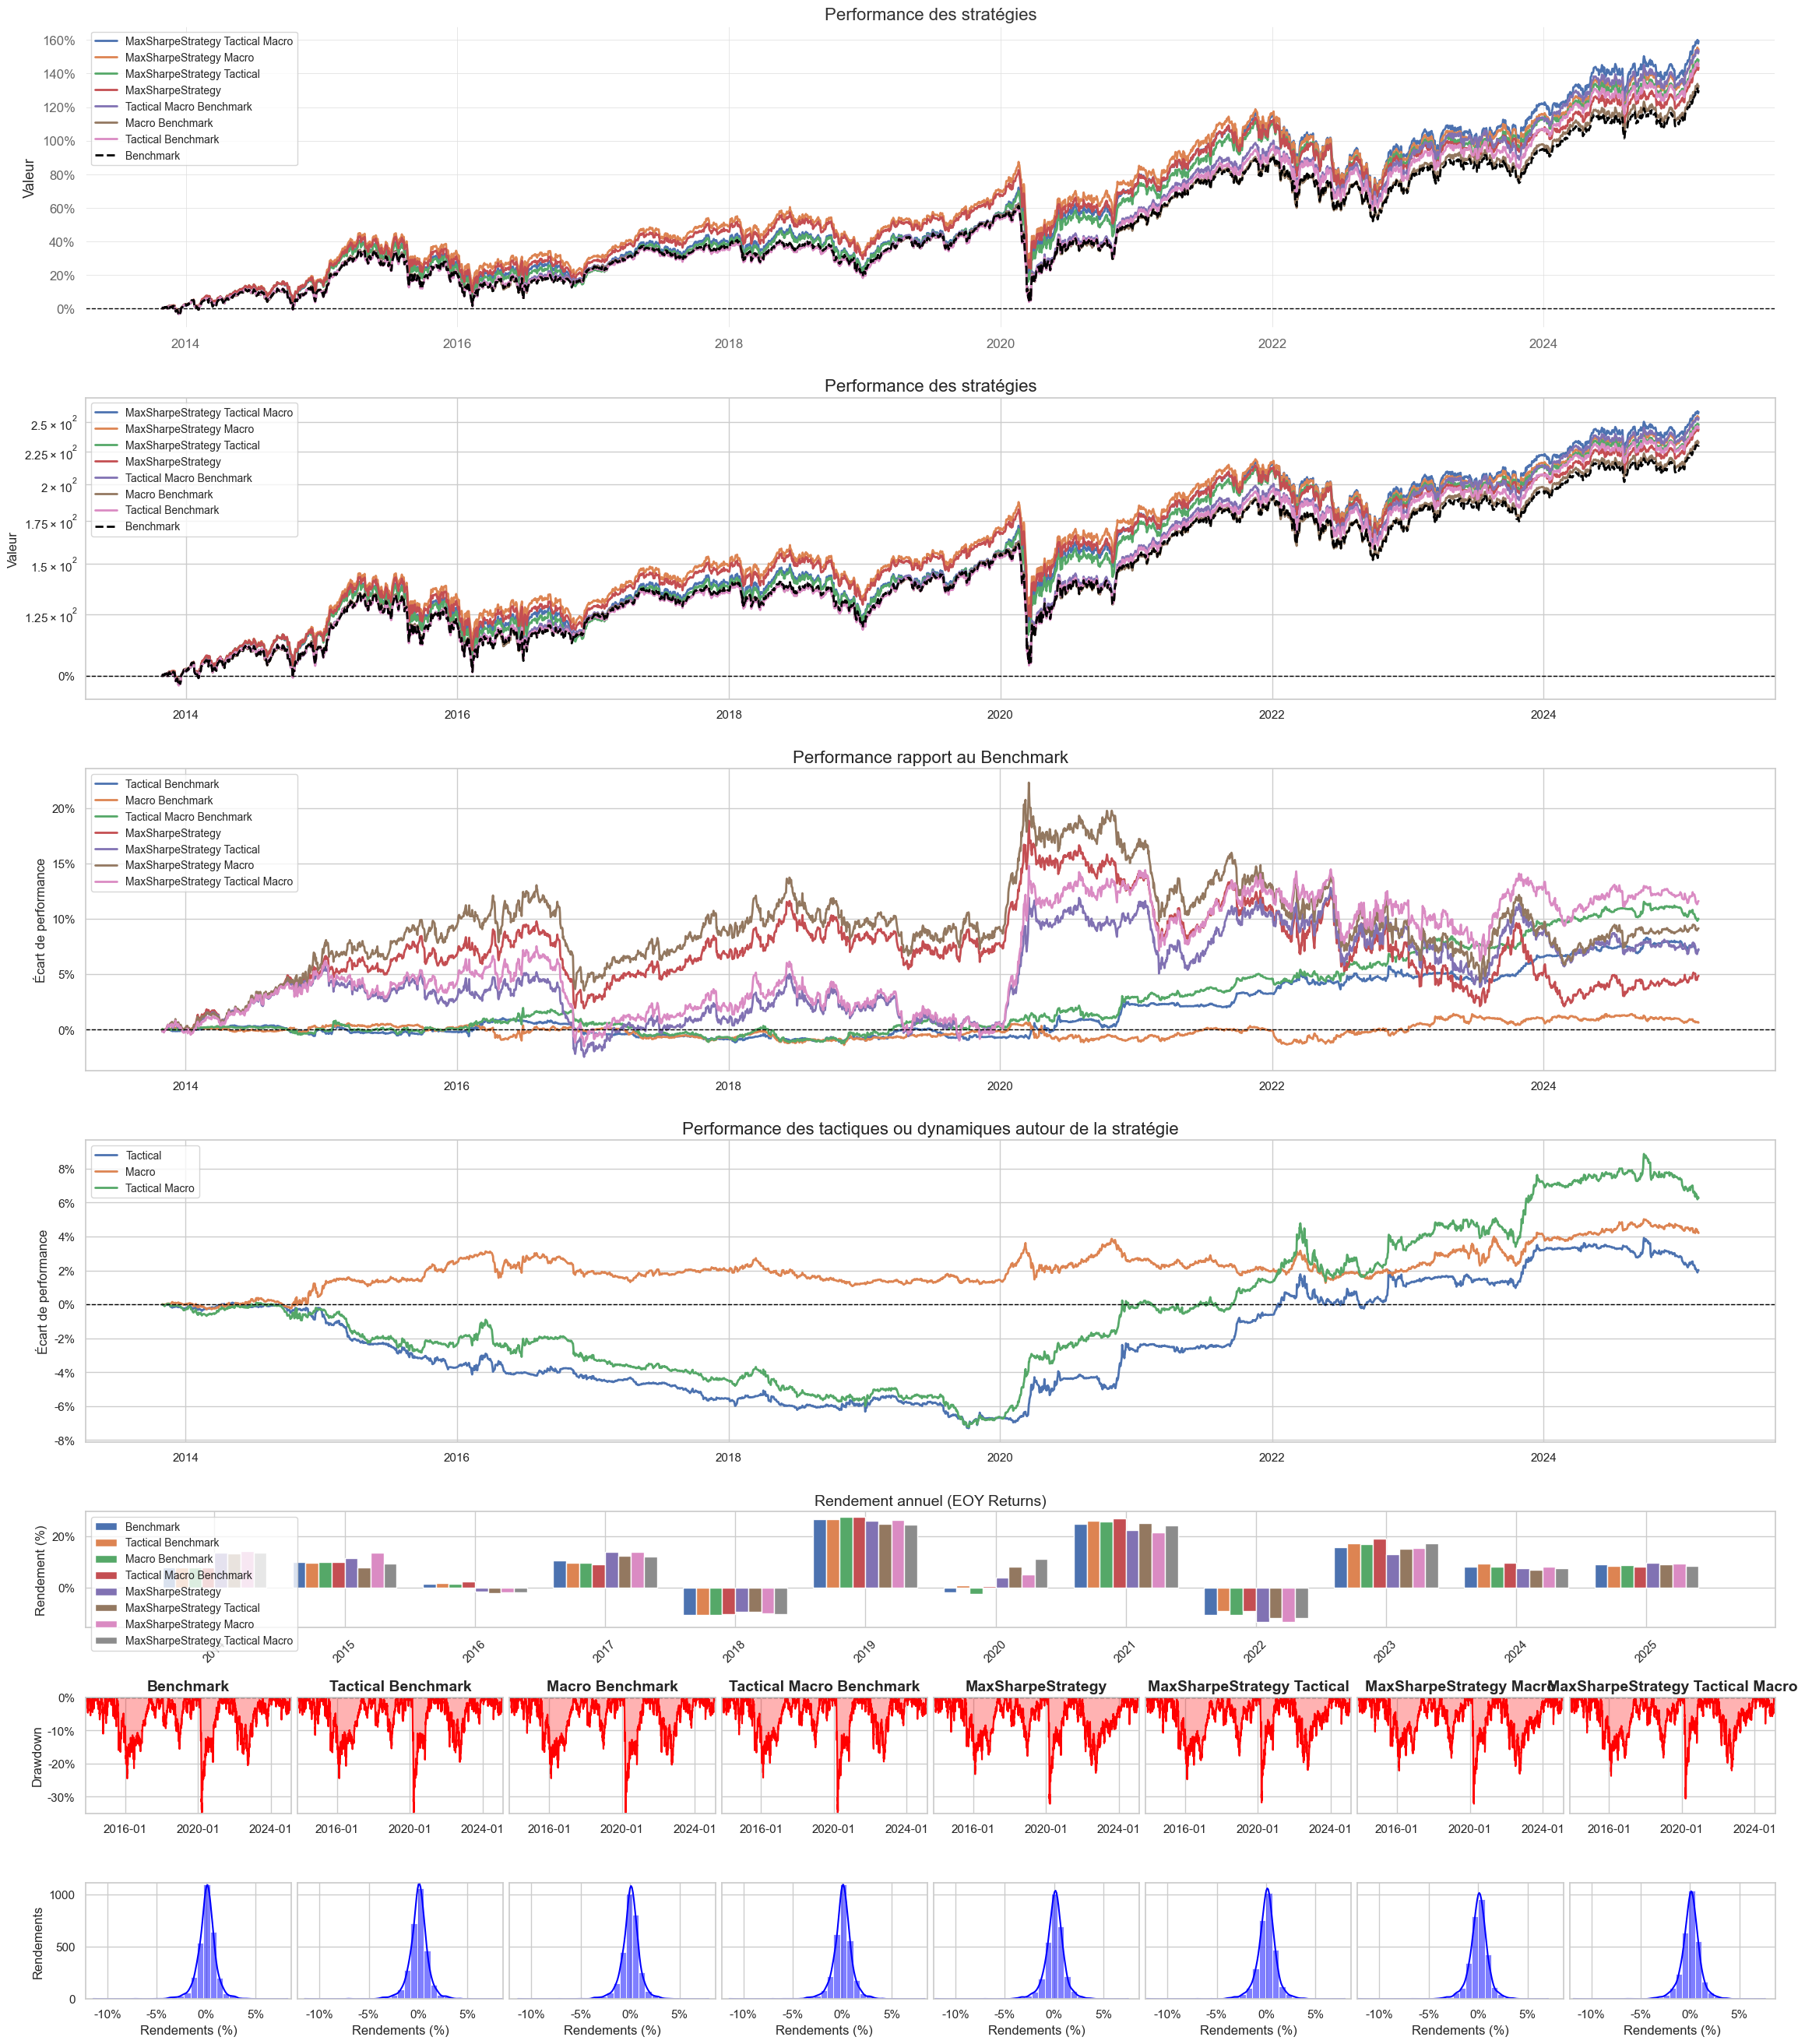

|                              | Benchmark   | Tactical Benchmark   | Macro Benchmark   | Tactical Macro Benchmark   | MaxSharpeStrategy   | MaxSharpeStrategy Tactical   | MaxSharpeStrategy Macro   | MaxSharpeStrategy Tactical Macro   |
|:-----------------------------|:------------|:---------------------|:------------------|:---------------------------|:--------------------|:-----------------------------|:--------------------------|:-----------------------------------|
| Performance                  | 130.01%     | 145.77%              | 132.66%           | 153.31%                    | 143.67%             | 148.11%                      | 143.67%                   | 159.34%                            |
| CAGR                         | 7.50%       | 8.12%                | 7.60%             | 8.40%                      | 8.04%               | 8.20%                        | 8.04%                     | 8.62%                              |
| Volatility                   | 15.71%      | 15.91

,Performance,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Win Rate,Average Win,Average Loss,Tracking Error
Benchmark,130.01%,7.50%,15.71%,-34.97%,0.54,75.00%,14.29%,-10.23%,0.00%
Tactical Benchmark,145.77%,8.12%,15.91%,-35.05%,0.57,75.00%,15.03%,-9.91%,1.11%
Macro Benchmark,132.66%,7.60%,15.46%,-34.88%,0.55,75.00%,14.38%,-10.06%,1.10%
Tactical Macro Benchmark,153.31%,8.40%,15.69%,-34.83%,0.59,75.00%,15.37%,-9.73%,1.38%
MaxSharpeStrategy,143.67%,8.04%,15.74%,-32.18%,0.57,75.00%,14.05%,-8.26%,4.36%
MaxSharpeStrategy Tactical,148.11%,8.20%,15.91%,-31.81%,0.58,66.67%,16.30%,-6.53%,4.05%
MaxSharpeStrategy Macro,143.67%,8.04%,15.74%,-32.18%,0.57,75.00%,14.05%,-8.26%,4.57%
MaxSharpeStrategy Tactical Macro,159.34%,8.62%,15.75%,-30.62%,0.60,66.67%,16.78%,-6.31%,4.38%


In [5]:
MSM.visualize()
MSM.gather_metrics(highlight_extremes=True)

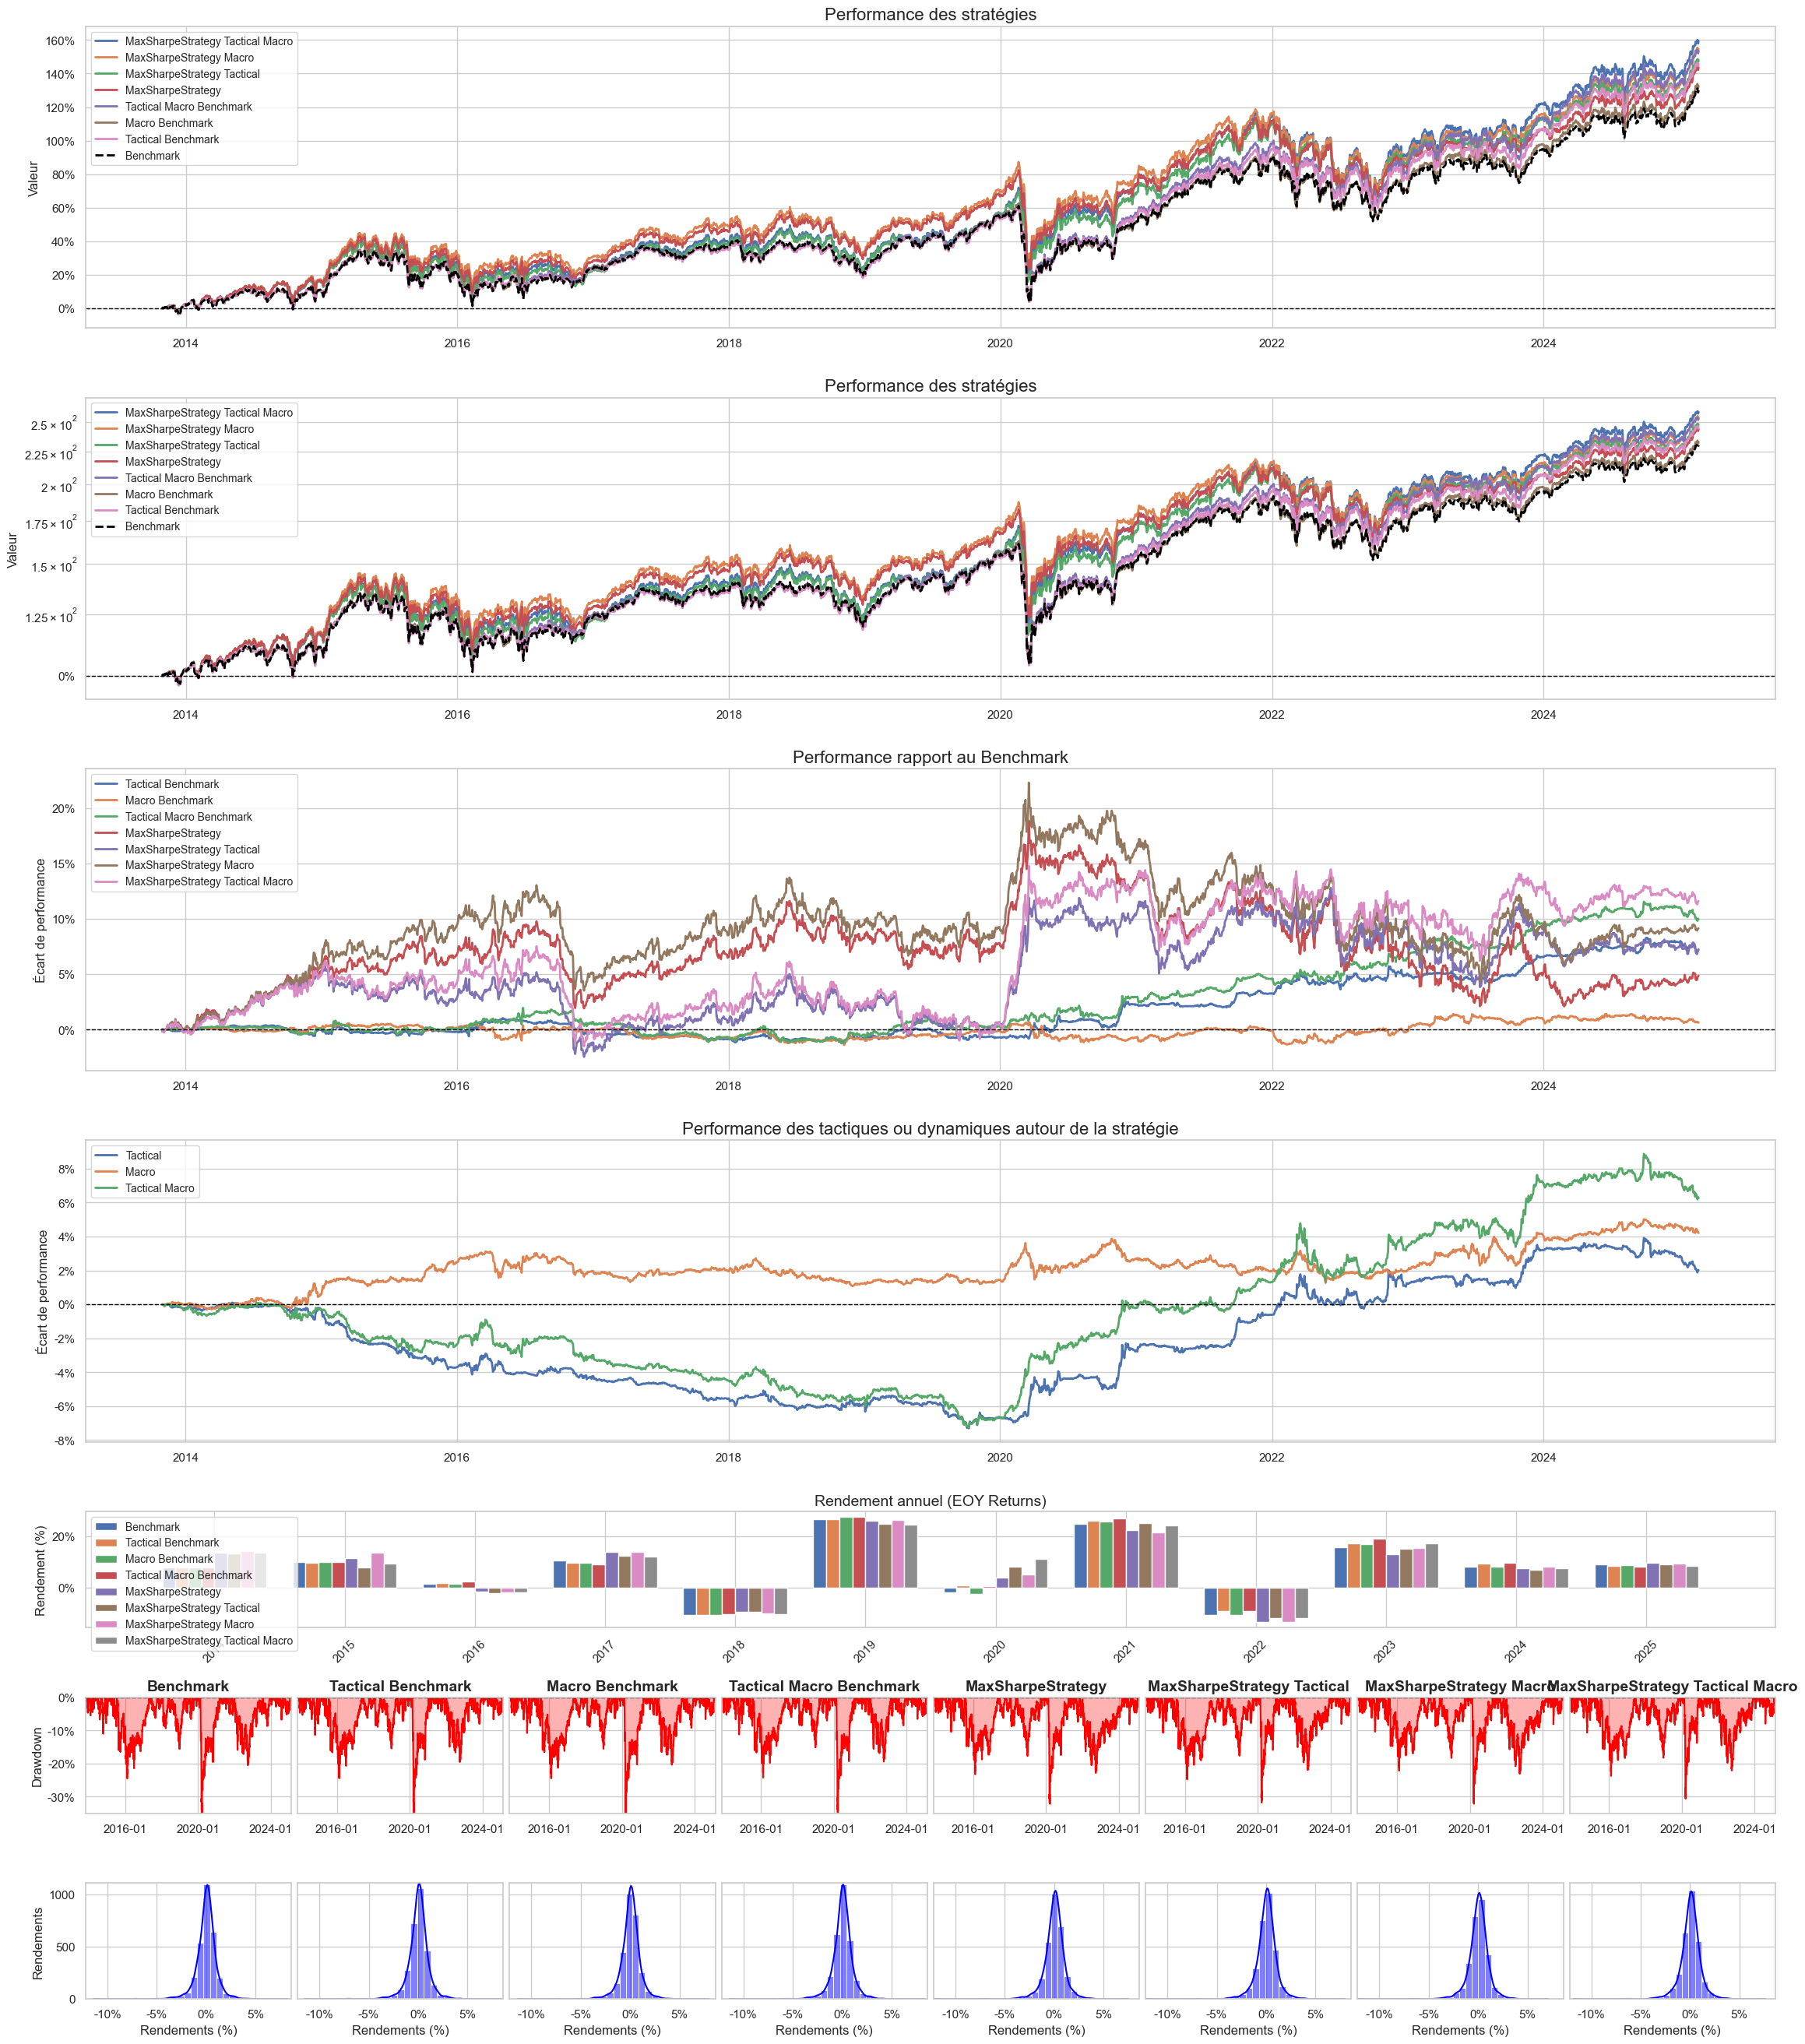

|                              | Benchmark   | Tactical Benchmark   | Macro Benchmark   | Tactical Macro Benchmark   | MaxSharpeStrategy   | MaxSharpeStrategy Tactical   | MaxSharpeStrategy Macro   | MaxSharpeStrategy Tactical Macro   |
|:-----------------------------|:------------|:---------------------|:------------------|:---------------------------|:--------------------|:-----------------------------|:--------------------------|:-----------------------------------|
| Performance                  | 130.01%     | 145.77%              | 132.66%           | 153.31%                    | 143.67%             | 148.11%                      | 143.67%                   | 159.34%                            |
| CAGR                         | 7.50%       | 8.12%                | 7.60%             | 8.40%                      | 8.04%               | 8.20%                        | 8.04%                     | 8.62%                              |
| Volatility                   | 15.71%      | 15.91

,Performance,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Win Rate,Average Win,Average Loss,Tracking Error
Benchmark,130.01%,7.50%,15.71%,-34.97%,0.54,75.00%,14.29%,-10.23%,0.00%
Tactical Benchmark,145.77%,8.12%,15.91%,-35.05%,0.57,75.00%,15.03%,-9.91%,1.11%
Macro Benchmark,132.66%,7.60%,15.46%,-34.88%,0.55,75.00%,14.38%,-10.06%,1.10%
Tactical Macro Benchmark,153.31%,8.40%,15.69%,-34.83%,0.59,75.00%,15.37%,-9.73%,1.38%
MaxSharpeStrategy,143.67%,8.04%,15.74%,-32.18%,0.57,75.00%,14.05%,-8.26%,4.36%
MaxSharpeStrategy Tactical,148.11%,8.20%,15.91%,-31.81%,0.58,66.67%,16.30%,-6.53%,4.05%
MaxSharpeStrategy Macro,143.67%,8.04%,15.74%,-32.18%,0.57,75.00%,14.05%,-8.26%,4.57%
MaxSharpeStrategy Tactical Macro,159.34%,8.62%,15.75%,-30.62%,0.60,66.67%,16.78%,-6.31%,4.38%


In [6]:
MSM.visualize()
MSM.gather_metrics(highlight_extremes=True)